In [ ]:
import random

# Set the random seed 
random.seed(1234)

In [ ]:
device = 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'Video', 'CW_Dataset', 'Models', 'test_functions.ipynb']


# Unzip and creating directory format of the dataset
In this section, we unzip the provided dataset, create a directory called 'dataset' with three subfolders: 'Train', 'Test', and 'Validation'. Within each subfolder, we have three additional subfolders for each image class labeled as 0, 1, and 2

In [ ]:
import os
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

In [ ]:
import os
import shutil

train_path = "./train/"


# Define path to the labels folder inside the train folder
train_labels_path = os.path.join(train_path, "labels")

# Define path to the images folder inside the train folder
train_images_path = os.path.join(train_path, "images")

# Create the folders for each class (0, 1, 2) inside the train folder
for class_id in range(3):
    class_path = os.path.join(train_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the train images folder and move them to the appropriate class folder
for image_name in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_name)
    label_path = os.path.join(train_labels_path, image_name[:-5] + ".txt") 
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(train_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))

In [ ]:
test_path = "./test/"

# Define path to the labels folder inside the test folder
test_labels_path = os.path.join(test_path, "labels")

# Define path to the images folder inside the test folder
test_images_path = os.path.join(test_path, "images")

# Create the folders for each class (0, 1, 2) inside the test folder
for class_id in range(3):
    class_path = os.path.join(test_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the test images folder and move them to the appropriate class folder
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name[:-5] + ".txt") 
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(test_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))

In [ ]:
# Delete the images and labels folders inside the train and test folders
shutil.rmtree(train_images_path)
shutil.rmtree(train_labels_path)
shutil.rmtree(test_images_path)
shutil.rmtree(test_labels_path)

In [ ]:
import os


# Get the current directory
current_dir = os.getcwd()

# Print the current directory
print("Current Directory: ", current_dir)

#shutil.rmtree('dataset')

## Create the directory
os.mkdir('dataset')

shutil.move('/content/test','/content/dataset')
shutil.move('/content/train','/content/dataset')

Current Directory:  /content


'/content/dataset/train'

In [ ]:
import os
import shutil
import random

# Set the path to the dataset folder
dataset_path = "dataset"

# Set the percentage of images to move to the validation folder
validation_percentage = 0.25

# Loop through the train folder
for class_folder in os.listdir(os.path.join(dataset_path, "train")):
    class_folder_path = os.path.join(dataset_path, "train", class_folder)
    if os.path.isdir(class_folder_path):
        # Get the list of images in the current class folder
        images = os.listdir(class_folder_path)
        # Calculate the number of images to move to the validation folder
        num_images = len(images)
        num_validation_images = int(num_images * validation_percentage)
        # Randomly select images to move to the validation folder
        validation_images = random.sample(images, num_validation_images)
        # Create the validation folder if it doesn't exist
        validation_folder_path = os.path.join(dataset_path, "val", class_folder)
        os.makedirs(validation_folder_path, exist_ok=True)
        # Move the selected images to the validation folder
        for image in validation_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(validation_folder_path, image)
            shutil.move(src, dst)
           

# Libraries

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import cv2

import os
%matplotlib inline

# Preprocessing & Loading 

In [ ]:

def calculate_mean_std(dataset_path, image_size=(32, 32)):
  
    image_files = []
    for label in ["0", "1", "2"]:
        label_folder = os.path.join(dataset_path, label)
        image_files.extend([os.path.join(label_folder, img_file) for img_file in os.listdir(label_folder)])

    # Load, resize, and normalize images
    images = []
    for img_file in image_files:
        image = cv2.imread(img_file)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        image = image / 255.0  # Normalize pixel values between 0 and 1
        images.append(image)

    # Calculate mean and standard deviation of RGB channels
    images = np.stack(images, axis=0)
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))

    return mean, std

In [ ]:
train_path = 'dataset/train'
data_means,data_stds = calculate_mean_std(train_path)

print(data_means)
print(data_stds)


[0.43909345 0.45864455 0.50142335]
[0.25572256 0.24742788 0.24570424]


In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

In [ ]:
data_dir ='dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)
print(dataset_sizes)


['0', '1', '2']
{'train': 1796, 'val': 598, 'test': 458}


### visualize some random examples 

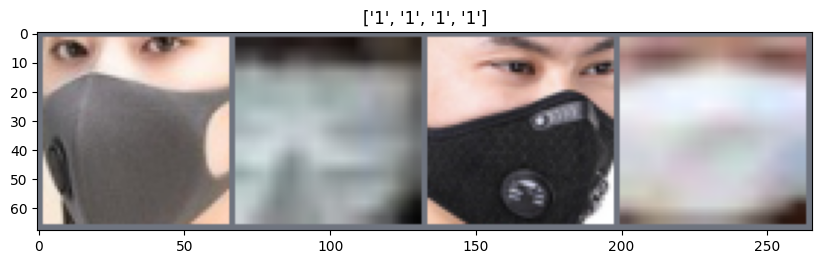

In [ ]:
# the function is adapted from lab 9

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()

# Training the model


In [ ]:
# the function is adapted from lab 9 computer vision 

def train_model(model, criterion, optimizer, scheduler, num_epochs=150):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            

            # deep copy the model with best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)


    return model

## Visualizing the model predictions


In [ ]:
# the function is adapted from lab 9 computer vision 

def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    print(len(dataloaders['val']))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the CNN

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [ ]:
#Create a new fully-connected layer and use it to replace the original one of Resnet18.
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 3.
model_ft.fc = nn.Linear(num_ftrs, 3)

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)


Epoch 0/29
----------------
train loss: 0.5397 acc: 0.8341
val loss: 0.2655 acc: 0.9181

Epoch 1/29
----------------
train loss: 0.4213 acc: 0.8714
val loss: 0.6932 acc: 0.7408

Epoch 2/29
----------------
train loss: 0.4919 acc: 0.8502
val loss: 0.3288 acc: 0.8645

Epoch 3/29
----------------
train loss: 0.3418 acc: 0.8920
val loss: 0.1830 acc: 0.9314

Epoch 4/29
----------------
train loss: 0.3045 acc: 0.8981
val loss: 0.2430 acc: 0.8980

Epoch 5/29
----------------
train loss: 0.2978 acc: 0.9065
val loss: 0.1445 acc: 0.9465

Epoch 6/29
----------------
train loss: 0.2727 acc: 0.9131
val loss: 0.1386 acc: 0.9515

Epoch 7/29
----------------
train loss: 0.2654 acc: 0.9170
val loss: 0.1580 acc: 0.9415

Epoch 8/29
----------------
train loss: 0.2302 acc: 0.9259
val loss: 0.1585 acc: 0.9398

Epoch 9/29
----------------
train loss: 0.2187 acc: 0.9365
val loss: 0.1250 acc: 0.9515

Epoch 10/29
----------------
train loss: 0.2093 acc: 0.9220
val loss: 0.1430 acc: 0.9482

Epoch 11/29
--------

### save model 

In [ ]:
import os 
import shutil

model_ft_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_transfer.pth')
torch.save(model_ft.state_dict(), model_ft_path)


### load model 

In [ ]:
import os 
import shutil

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_transfer.pth')
model_ft.load_state_dict(torch.load(model_ft_path))

<All keys matched successfully>

150


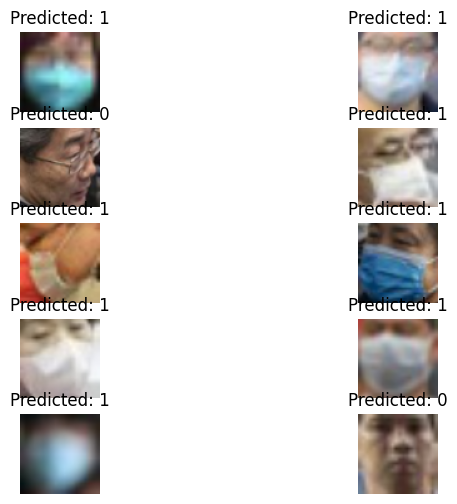

In [ ]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

# Test
### Testing the network on the entire testset & confusion matrix & predict time 

Time elapsed: 5.52 seconds
Accuracy of the network on the 458 test images: 94.5414847161572%
class accuracy [78.43137255 99.48453608 36.84210526]


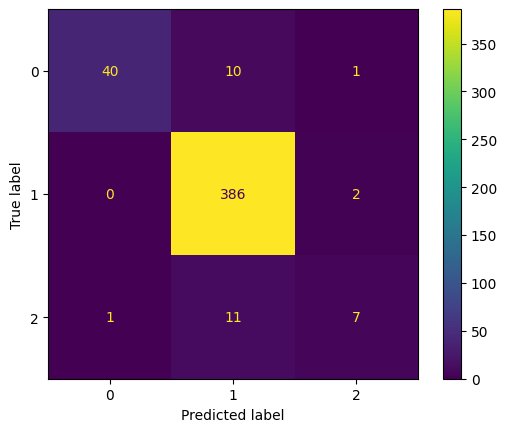

In [ ]:
from sklearn.metrics import confusion_matrix

model_ft.eval()

# Estimate average accuracy
correct = 0
total = 0
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# prediction time 
import time
start_time = time.time()

with torch.no_grad():             # Avoid backprop at test 
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
  
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

end_time = time.time()

# Time elapsed
elapsed_time = end_time - start_time
print("Time elapsed: {:.2f} seconds".format(elapsed_time))


print(f"Accuracy of the network on the 458 test images: {100 * correct / total}%")
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print('class accuracy',class_accuracy)


from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(lbllist.numpy(), predlist.numpy())
plt.show()